Tutorial

This tutorial shows the basic steps of using SEP to detect objects in an image and perform some basic aperture photometry.

Here, we use the fitsio package, just to read the test image, but you can also use astropy.io.fits for this purpose (or any other FITS reader).

In [27]:
import numpy as np
import sep

In [28]:
# additional setup for reading the test image and displaying plots
import fitsio
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

First, we’ll read an example image from a FITS file and display it, just to show what we’re dealing with. The example image is just 256 x 256 pixels.

In [29]:
# read image into standard 2-d numpy array
data = fitsio.read("../data/image.fits")

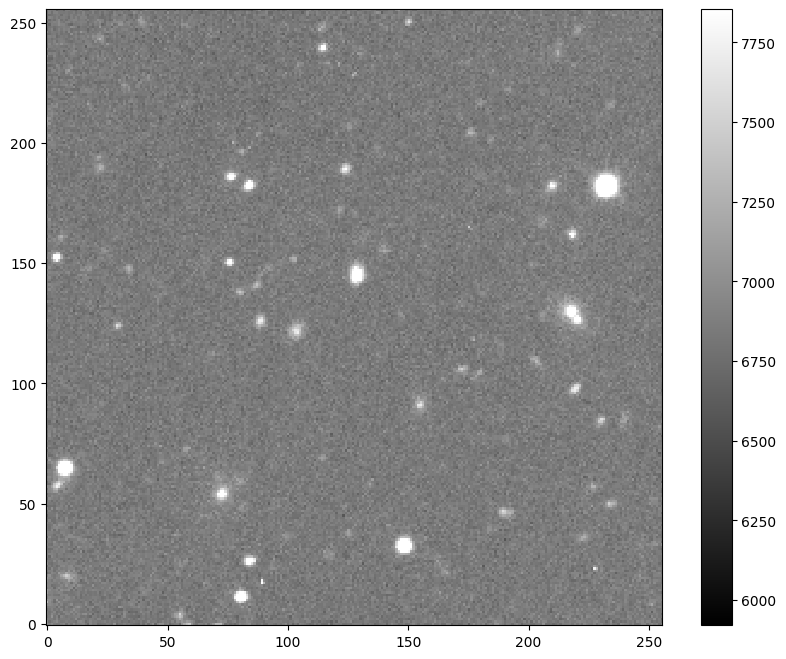

In [30]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
fig.savefig("image.png", bbox_inches="tight",)

Background subtraction

Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

In [31]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

There are various options for controlling the box size used in estimating the background. It is also possible to mask pixels. For example:

bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)

See the reference section for descriptions of these parameters.

This returns an Background object that holds information on the spatially varying background and spatially varying background noise level. We can now do various things with this Background object:

In [32]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46165466308594


In [33]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

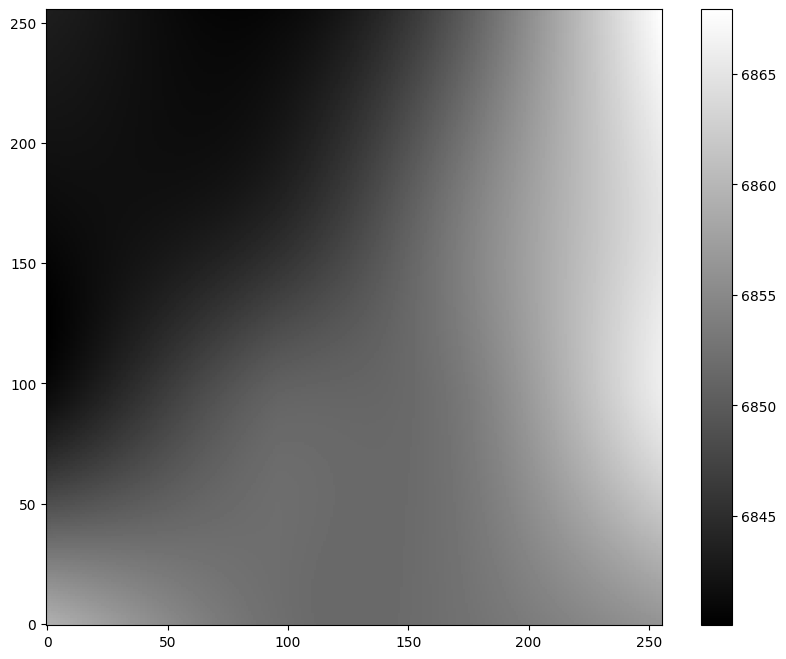

In [34]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
fig.savefig("background.png", bbox_inches="tight",)

In [35]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

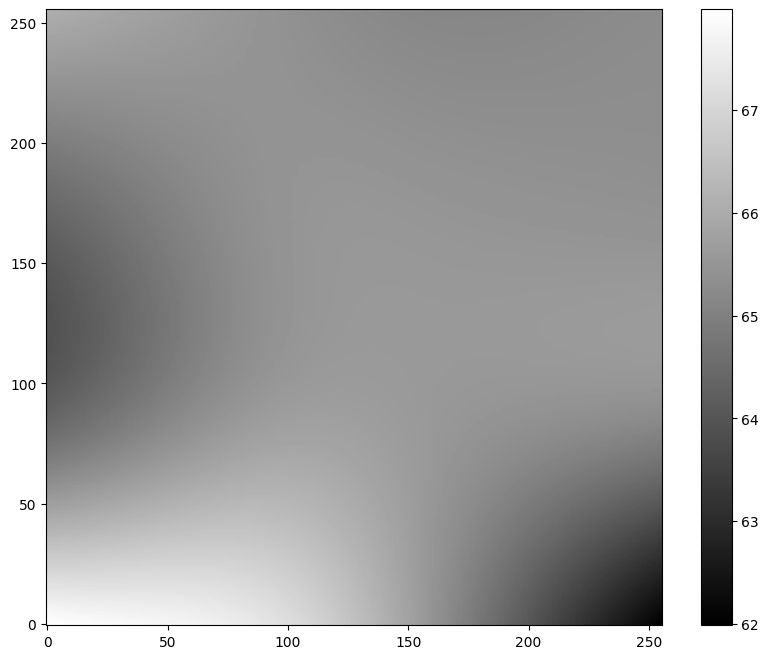

In [36]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
fig.savefig("background_noise.png", bbox_inches="tight",)

In [37]:
# subtract the background
data_sub = data - bkg

Object detection

Now that we’ve subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we’re setting the detection threshold to be a constant value of 1.5𝜎 where 𝜎 is the global background RMS.

In [38]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

sep.extract has many options for controlling detection threshold, pixel masking, filtering, and object deblending. See the reference documentation for details.

objects is a NumPy structured array with many fields.

In [39]:
# how many objects were detected
len(objects)

68

objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detected objects are, we’ll over-plot the object coordinates with some basic shape parameters on the image:

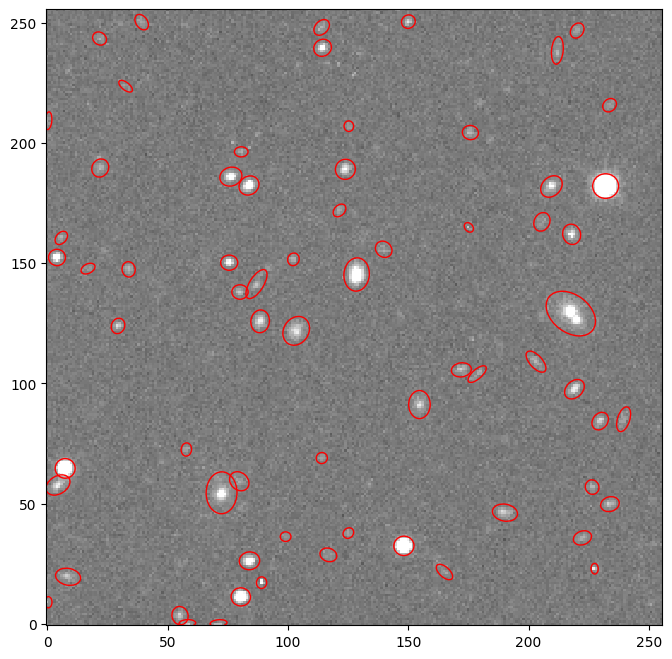

In [40]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
fig.savefig("objects.png", bbox_inches="tight",)

objects has many other fields, giving information such as second moments, and peak pixel positions and values. See the reference documentation for sep.extract for descriptions of these fields. You can see the available fields:

In [41]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

Aperture photometry

Finally, we’ll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [42]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

flux, fluxerr and flag are all 1-d arrays with one entry per object.

In [43]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2249.170391 +/- 291.027417
object 1: flux = 3092.230840 +/- 291.591822
object 2: flux = 5949.880234 +/- 356.561536
object 3: flux = 1851.424668 +/- 295.028402
object 4: flux = 72736.399336 +/- 440.171829
object 5: flux = 3860.769043 +/- 352.162694
object 6: flux = 6418.912480 +/- 357.458487
object 7: flux = 2210.748574 +/- 350.790791
object 8: flux = 2741.596953 +/- 352.277241
object 9: flux = 20916.880059 +/- 376.965686
